In [194]:
import os
import sys
import windrose
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cm as cm
import numpy as np
from datetime import datetime, timedelta, timezone

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

unflagged_data = False

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)
    
from utils.paths import DESPIKED_DATA_DIRECTORY, PROCESSED_PICARRO_DATA_DIRECTORY
from utils.import_data import import_acropolis_site_data
from config.sites_deloyment_times import deployment_times

assert(os.path.exists(DESPIKED_DATA_DIRECTORY))
assert(os.path.exists(PROCESSED_PICARRO_DATA_DIRECTORY))

In [195]:
def get_site(site:str):
    return import_acropolis_site_data(target_directory=DESPIKED_DATA_DIRECTORY,
                                        deployment_times=deployment_times,
                                        site_name=site)

In [196]:
def insert_nan_gaps(x, y, max_gap_minutes=60):
    x = np.array(x)
    y = np.array(y)
    x_diff = np.diff(x).astype("timedelta64[m]").astype(int)
    gap_indices = np.where(x_diff > max_gap_minutes)[0] + 1

    x_new = []
    y_new = []

    prev_idx = 0
    for gap_idx in gap_indices:
        x_new.extend(x[prev_idx:gap_idx])
        y_new.extend(y[prev_idx:gap_idx])
        # insert NaN to break the line
        x_new.append(x[gap_idx-1] + (x[gap_idx] - x[gap_idx-1]) / 2)
        y_new.append(np.nan)
        prev_idx = gap_idx

    x_new.extend(x[prev_idx:])
    y_new.extend(y[prev_idx:])

    return np.array(x_new), np.array(y_new)

In [197]:
# Filters
start_date = datetime(2025, 3, 27, 12, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2025, 3, 28, 12, 0, 0).replace(tzinfo=timezone.utc)

df_plot = get_site("MAIR").filter(pl.col("datetime").is_between(start_date, end_date))

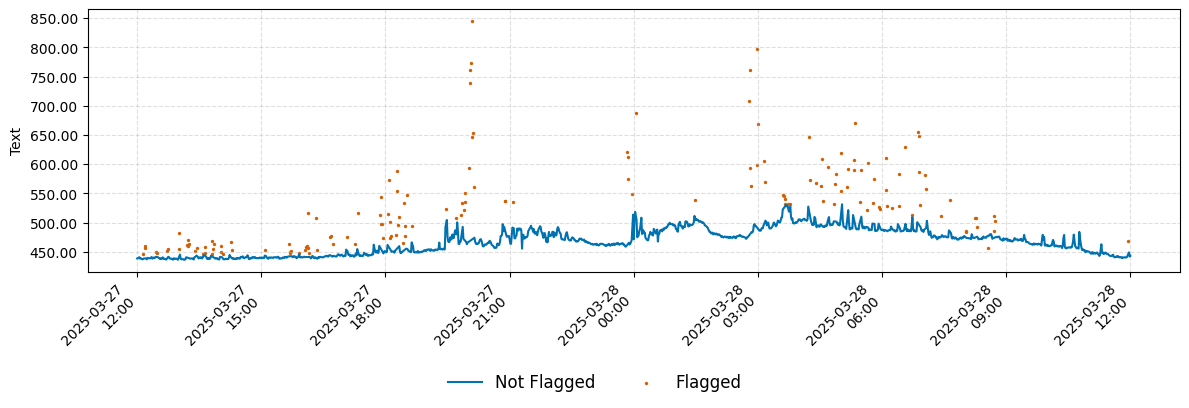

In [198]:
y_col_name = "gmp343_corrected"
y_title = "Text"
figsize = (12, 4)
dpi = 100
n_rows = 1
n_cols = 1
system_id = 3


fig, axes = plt.subplots(n_rows, n_cols,
                            figsize=figsize, dpi=dpi,
                            sharex=False, sharey=True)

axes = np.array(axes).reshape(n_rows, n_cols)

# First plot
row, col = divmod(0, n_cols)
ax = axes[row, col]

# System 6
system_id = 6

x_u = df_plot.filter(pl.col("Flag") == "U").get_column("datetime").to_numpy()
x_nu = df_plot.filter(pl.col("Flag") != "U").get_column("datetime").to_numpy()
y_u = df_plot.filter(pl.col("Flag") == "U").get_column(y_col_name).to_numpy()
y_nu = df_plot.filter(pl.col("Flag") != "U").get_column(y_col_name).to_numpy()

x_u, y_u = insert_nan_gaps(x_u, y_u, max_gap_minutes=60)
x_nu, y_nu = insert_nan_gaps(x_nu, y_nu, max_gap_minutes=60)

# Scatter
ax.plot(x_u, y_u, color="#0072B2", alpha=1, label=f"Not Flagged")
ax.scatter(x_nu, y_nu, color="#D55E00", alpha=1, s=2, label=f"Flagged")


ax.set_ylabel(y_title)
#y_lim = (-10, 45)
#ax.set_ylim(y_lim)

ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.grid(True, linestyle='--', alpha=0.4)

# Set x axis format
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

fig.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.03),
    ncol=2,
    frameon=False,
    fontsize=12,
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

# Wind Rose

In [199]:
from windrose import WindroseAxes

def plot_wind_rose(ws, wd, bins=None, calm_threshold=0.5):
    """
    Plot a windrose with 16 direction bins but only 8 cardinal labels.

    Parameters:
    ----------
    ws : np.ndarray
        Wind speed values (same length as wd).
    wd : np.ndarray
        Wind direction values in degrees (0-360°).
    bins : list or None
        Wind speed bins to be used for color legend.
    calm_threshold : float
        Wind speeds below this are considered 'calm' and not plotted.
    """
    # Clean inputs
    wd = wd[(ws > calm_threshold)]
    ws = ws[(ws > calm_threshold)]

    # Create windrose axes
    ax = WindroseAxes.from_ax()
    ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white', bins=bins or np.linspace(0, np.max(ws), 5))

    # Set 16 sectors (22.5° bins)
    ax.set_thetagrids(angles=np.arange(0, 360, 22.5))

    # Set labels only for the 8 main directions
    main_dirs = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    ax.set_thetagrids(
        angles=np.arange(0, 360, 45),
        labels=main_dirs
    )

    # Optional aesthetics
    ax.set_legend(title='Wind speed (m/s)', loc='lower right', fontsize=9)
    ax.set_title("Wind Rose", fontsize=14, pad=20)
    plt.show()
    

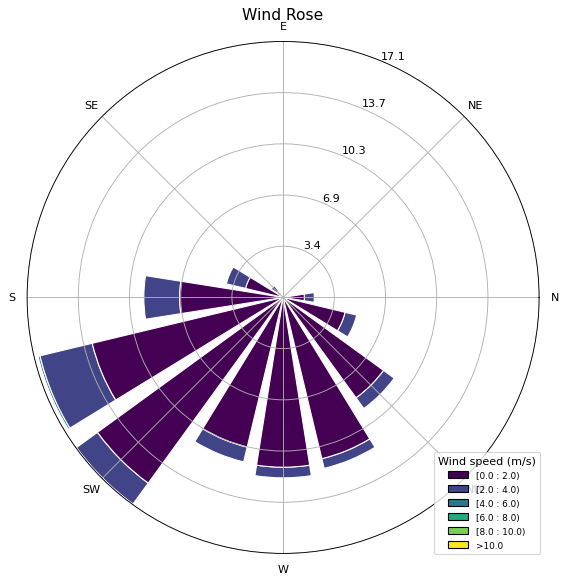

In [200]:
# Filters
start_date = datetime(2024, 1, 1, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 10, 21, 0, 0, 0).replace(tzinfo=timezone.utc)

df_plot = get_site("RDIR").filter(pl.col("datetime").is_between(start_date, end_date))

df_wr = df_plot.select(["datetime", "wxt532_speed_avg", "wxt532_direction_avg", "Flag"]) \
    .filter(pl.col("Flag") == "H") \
    .filter(pl.col("wxt532_direction_avg") > 0) \
    .filter(pl.col("wxt532_speed_avg") > 0)
    
wd = df_wr.get_column("wxt532_direction_avg").to_numpy()
ws = df_wr.get_column("wxt532_speed_avg").to_numpy()

plot_wind_rose(ws, wd, bins=[0, 2, 4, 6, 8, 10])

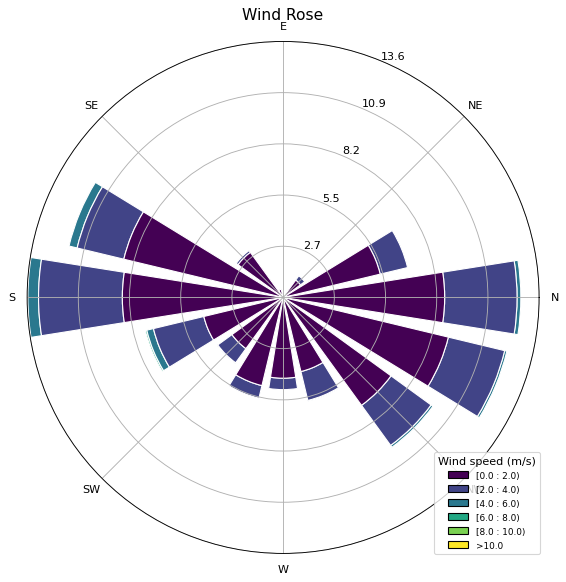

In [201]:
# Filters
start_date = datetime(2024, 10, 21, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2025, 7, 1, 0, 0, 0).replace(tzinfo=timezone.utc)

df_plot = get_site("RDIR").filter(pl.col("datetime").is_between(start_date, end_date))

df_wr = df_plot.select(["datetime", "wxt532_speed_avg", "wxt532_direction_avg", "Flag"]) \
    .filter(pl.col("Flag") == "H") \
    .filter(pl.col("wxt532_direction_avg") > 0) \
    .filter(pl.col("wxt532_speed_avg") > 0)
    
wd = df_wr.get_column("wxt532_direction_avg").to_numpy()
ws = df_wr.get_column("wxt532_speed_avg").to_numpy()

plot_wind_rose(ws, wd, bins=[0, 2, 4, 6, 8, 10])

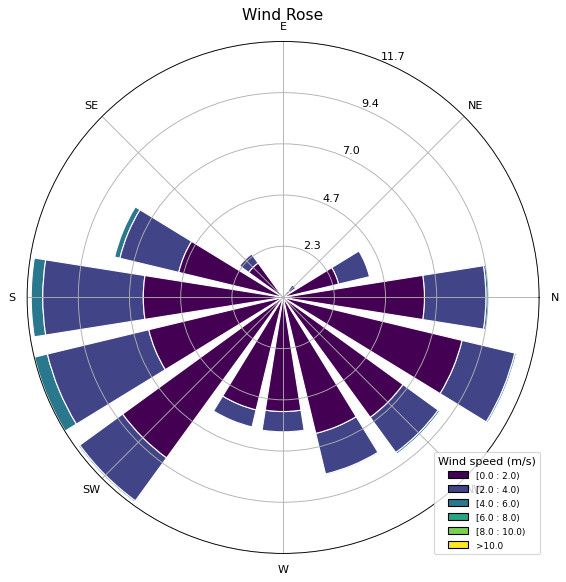

In [202]:
df_plot = get_site("RDIR")

df_wr = df_plot.select(["datetime", "wxt532_speed_avg", "wxt532_direction_avg", "Flag"]) \
    .filter(pl.col("Flag") == "U") \
    .filter(pl.col("wxt532_direction_avg") > 0) \
    .filter(pl.col("wxt532_speed_avg") > 0)
    
wd = df_wr.get_column("wxt532_direction_avg").to_numpy()
ws = df_wr.get_column("wxt532_speed_avg").to_numpy()

plot_wind_rose(ws, wd, bins=[0, 2, 4, 6, 8, 10])

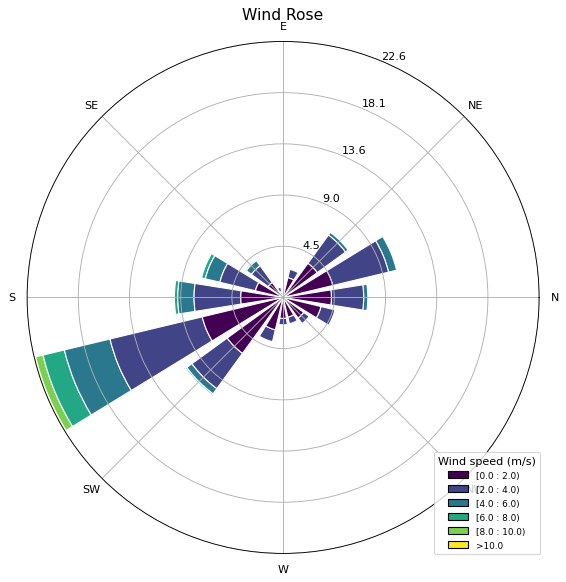

In [206]:
df_plot = get_site("MAIR")

df_wr = df_plot.select(["datetime", "wxt532_speed_avg", "wxt532_direction_avg", "Flag"]) \
    .filter(pl.col("Flag") == "U") \
    .filter(pl.col("wxt532_direction_avg") > 0) \
    .filter(pl.col("wxt532_speed_avg") > 0)
    
wd = df_wr.get_column("wxt532_direction_avg").to_numpy()
ws = df_wr.get_column("wxt532_speed_avg").to_numpy()

plot_wind_rose(ws, wd, bins=[0, 2, 4, 6, 8, 10])

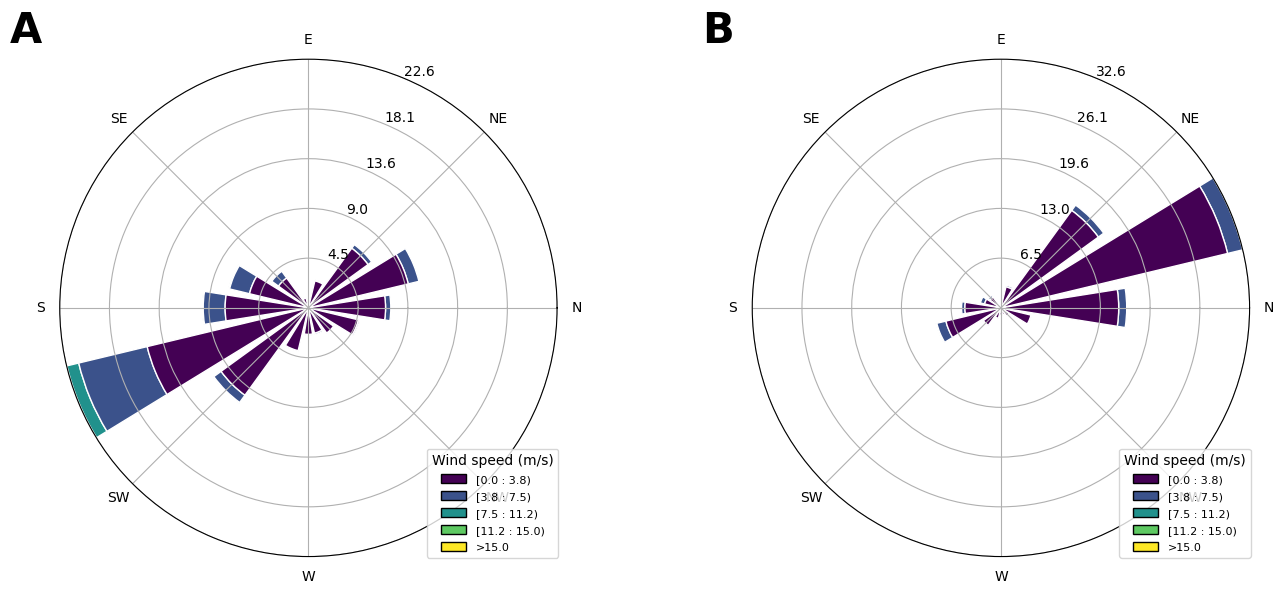

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from windrose import WindroseAxes

import numpy as np
import matplotlib.pyplot as plt
from windrose import WindroseAxes

def plot_contamination_windrose(wd_H, ws_H, wd_U, ws_U, calm_threshold=0.5):

    # Filter & clean data
    mask_H = (ws_H > calm_threshold) & (wd_H >= 0)
    mask_U = (ws_U > calm_threshold) & (wd_U >= 0)

    wd_H_clean = wd_H[mask_H]
    ws_H_clean = ws_H[mask_H]
    wd_U_clean = wd_U[mask_U]
    ws_U_clean = ws_U[mask_U]

    # Define synced wind speed bins based on combined data
    combined_ws = np.concatenate([ws_H_clean, ws_U_clean])
    max_speed = np.ceil(np.max(combined_ws))
    speed_bins = np.linspace(0, max(2, max_speed), num=5)

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw=dict(projection='windrose'))

    # Flag U
    axs[0].bar(wd_U_clean, ws_U_clean, normed=True, bins=speed_bins,
               opening=0.8, edgecolor='white')
    axs[0].set_thetagrids(np.arange(0, 360, 45),
                          labels=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

    # Flag H
    axs[1].bar(wd_H_clean, ws_H_clean, normed=True, bins=speed_bins,
               opening=0.8, edgecolor='white')
    axs[1].set_thetagrids(np.arange(0, 360, 45),
                          labels=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

    # Add subplot labels "A" and "B"
    panel_labels = ['A', 'B']
    for i, ax in enumerate(axs):
        ax.text(-0.1, 1.1, panel_labels[i], transform=ax.transAxes,
                fontsize=30, fontweight='bold', va='top', ha='left')

        ax.set_legend(title='Wind speed (m/s)', loc='lower right', fontsize=9)

    plt.tight_layout()
    plt.show()
    
# Filter your data
df_U = get_site("MAIR").filter(pl.col("Flag") == "U")
df_H = get_site("MAIR").filter(pl.col("Flag") == "H")

wd_U = df_U["wxt532_direction_avg"].to_numpy()
ws_U = df_U["wxt532_speed_avg"].to_numpy()
wd_H = df_H["wxt532_direction_avg"].to_numpy()
ws_H = df_H["wxt532_speed_avg"].to_numpy()

# Plot
plot_contamination_windrose(wd_H, ws_H, wd_U, ws_U)